In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

# Loading the data into Tensorflow Dataset

In [3]:
dataset=tf.keras.utils.image_dataset_from_directory(
        'PlantVillage', shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Creating Train, Test, and Validation Datasets

In [5]:
def get_ds_partitions(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        
        train_ds = ds.take(int(len(ds)*train_split))
        test_ds = ds.skip(int(len(ds)*train_split))
        val_ds = test_ds.take(int(len(ds)*val_split))
        test_ds = test_ds.skip(int(len(ds)*val_split))
        return train_ds, test_ds, val_ds

In [6]:
train_ds, test_ds, val_ds = get_ds_partitions(dataset, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000)
print(len(train_ds), len(test_ds), len(val_ds))

54 8 6


# Optimizing datasets with Catche and Prefetch for faster processing

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Scaling the datasets

In [8]:
scaler = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation 

In [9]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Building CNN model

In [10]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    scaler,
    augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')   
])
model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['acc']
)

history = model.fit(train_ds, epochs=20, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/20
54/54 [==============================] - 88s 2s/step - loss: 0.9191 - acc: 0.4786 - val_loss: 0.8266 - val_acc: 0.5938
Epoch 2/20
54/54 [==============================] - 83s 2s/step - loss: 0.6426 - acc: 0.7089 - val_loss: 0.5552 - val_acc: 0.7708
Epoch 3/20
54/54 [==============================] - 86s 2s/step - loss: 0.4420 - acc: 0.8003 - val_loss: 0.3511 - val_acc: 0.8646
Epoch 4/20
54/54 [==============================] - 84s 2s/step - loss: 0.3344 - acc: 0.8634 - val_loss: 0.2143 - val_acc: 0.9115
Epoch 5/20
54/54 [==============================] - 88s 2s/step - loss: 0.2802 - acc: 0.8976 - val_loss: 0.2045 - val_acc: 0.9271
Epoch 6/20
54/54 [==============================] - 85s 2s/step - loss: 0.2642 - acc: 0.8906 - val_loss: 0.2591 - val_acc: 0.8802
Epoch 7/20
54/54 [==============================] - 85s 2s/step - loss: 0.2033 - acc: 0.9190 - val_loss: 0.2272 - val_acc: 0.9167
Epoch 8/20
54/54 [==============================] - 85s 2s/step - loss: 0.1824 - acc: 0.92

In [25]:
model.model.save('C:\Model3')

AttributeError: 'Sequential' object has no attribute 'model'

Text(0.5, 1.0, 'Training and Validation Loss')

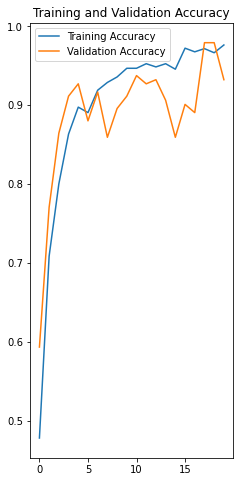

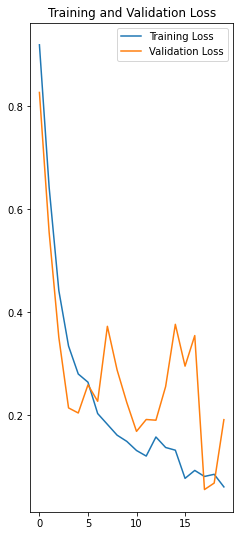

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), history.history['acc'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,9))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

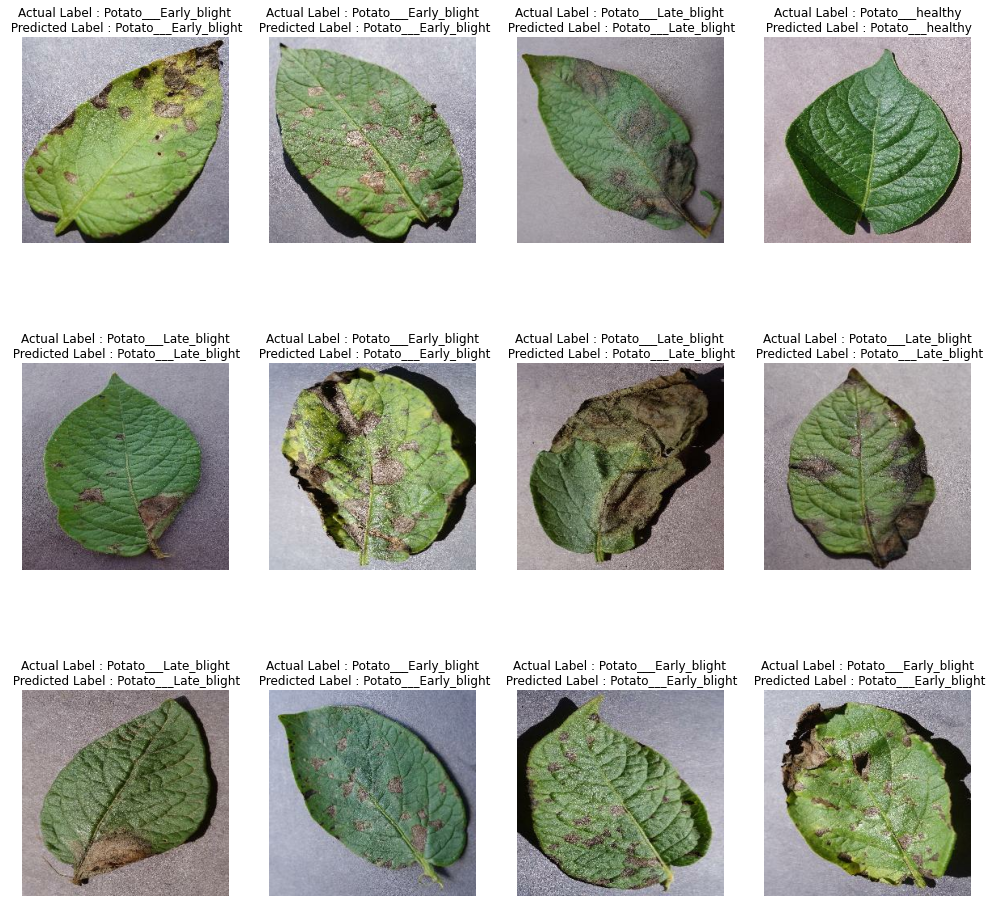

In [18]:
y_predicted = model.predict(test_ds)
plt.figure(figsize=(17,17))
for img, label in test_ds.take(1):
  for i in range(12):
      plt.subplot(3,4,i+1)
      plt.axis('off')
      image = plt.imshow(img[i].numpy().astype('uint8'))
      image_label_actual = dataset.class_names[label[i]]
      image_label_predicted = dataset.class_names[np.argmax(model.predict(img)[i])]
      plt.title(f'Actual Label : {image_label_actual}\n Predicted Label : {image_label_predicted}')
